In [4]:
import simpy
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.stats as st


import itertools

2) Discrete Event Simulation

In [1]:
def Queue(env, n_persons, lambd, servers, waiting_times_list, serving_rate):
    """queue gets customers randomly"""
    for _ in range(n_persons):
        # person = Person(env, servers, waiting_times_list, serving_rate)
        # env.process(person)
        arrival_time = np.random.exponential(1.0/lambd)
        yield env.timeout(arrival_time)
        person = Person(env, servers, waiting_times_list, serving_rate)
        env.process(person)
        

def Person(env, servers, waiting_times_list, serving_rate):
    """People arrive, wait in queue, are served and leave."""
    arrive = env.now

    with servers.request() as req:
        yield req

        wait = env.now - arrive
        waiting_times_list.append(wait)

        serving_time = np.random.exponential(1.0/serving_rate)
        yield env.timeout(serving_time)

def run_simulation(lambd, n, mu, n_persons, waiting_times_list, runs, scheduling_type):
    env = simpy.Environment()
    serving_rate = mu
    for _ in range(runs):
        if scheduling_type == 'FIFO':
            servers = simpy.Resource(env, capacity=n)
        elif scheduling_type == 'SJF':
            servers = simpy.PriorityResource(env, capacity = n)
        else:
            raise ValueError('invalid scheduling type')
        env.process(Queue(env, n_persons, lambd, servers, waiting_times_list, serving_rate))
        env.run()

    return waiting_times_list


In [37]:
class Queue:
    def __init__(self,env,n_servers,rho,mu,scheduling_type = 'FIFO'):
        self.env = env
        self.scheduling_type = scheduling_type
        self.mu = mu
        self.rho = rho
        self.lambd = rho*(n_servers*mu)
        self.cust = 0
        self.arrival_time = 0
        self.service_start_time = 0
        # self.servers = simpy.Resource(env,capacity = n_servers)

        if scheduling_type == 'FIFO':
            self.server = simpy.Resource(env, capacity=n_servers)
        elif scheduling_type == 'SJF':
            self.server = simpy.PriorityResource(env,capacity=n_servers)

    def arrive(self, n_customers,wait_times_list):
        while self.cust < n_customers:
            yield self.env.timeout(np.random.exponential(1/self.lambd))
            self.cust+=1
            self.env.process(self.service(wait_times_list))
    
    def service(self, wait_times_list):
        self.arrival_time = self.env.now
        job_length = np.random.exponential(1/self.mu)

        if self.scheduling_type == 'FIFO':
            with self.server.request() as req:
                yield req
                self.service_start_time = self.env.now
                wait_times_list.append(self.service_start_time - self.arrival_time)
                yield self.env.timeout(job_length)

        elif self.scheduling_type == 'SJF':
            with self.server.request(priority = job_length) as req:
                self.service_start_time = self.env.now
                yield req
                wait_times_list.append(self.service_start_time - self.arrival_time)
                yield self.env.timeout(job_length)
    
    def run_sim(self, n_customers):
        wait_times_list = []
        self.env.process(self.arrive(n_customers, wait_times_list))
        self.env.run()
        return wait_times_list
        

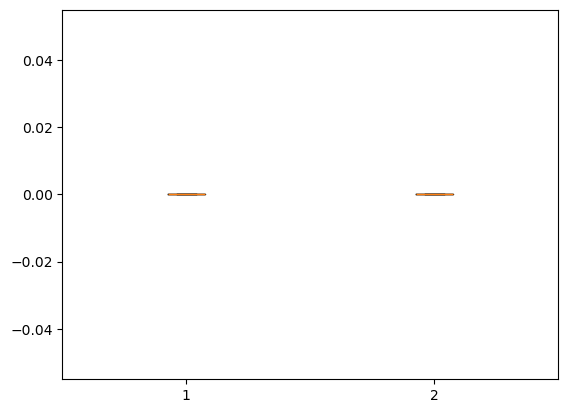

In [38]:
runs = 1000
n_customers = 500
rho = 0.8
mu = 1/2

env = simpy.Environment()

wait_total_n1 = []
wait_total_n2 = []
for i in range(runs):
    MM1queue_fifo = Queue(env,1,rho,mu,'SJF')
    MM2queue_fifo = Queue(env,2,rho,mu,'SJF')

    wait_times_list_1 = MM1queue_fifo.run_sim(n_customers)
    wait_times_list_2 = MM2queue_fifo.run_sim(n_customers)
    
    wait_total_n1.extend(wait_times_list_1)
    wait_total_n2.extend(wait_times_list_2)

# wait_times_1 = MM1queue_fifo.run_sim(n_customers)
# wait_times_2 = MM2queue_fifo.run_sim(n_customers)

positions = [1,2]
plt.boxplot([wait_total_n1,wait_total_n2],positions=positions)
plt.show()


System load 1 server: 2.0
System load 2 servers: 1.0
System load 4 servers: 0.5


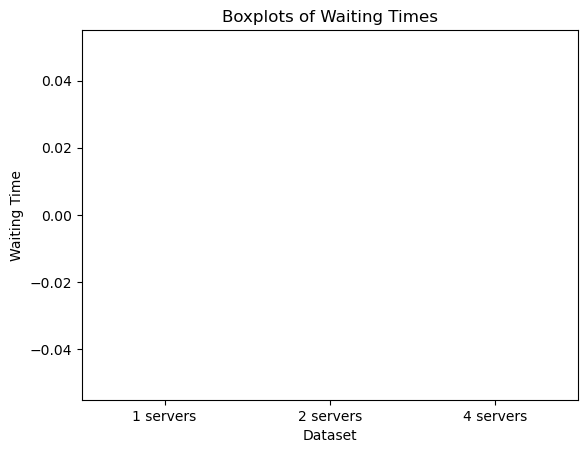

In [65]:
np.random.seed(3)

# λ – the arrival rate into the system as a whole.
# interval customers
lambd = 1

# μ – the capacity of each of n equal servers. 
mu = 1/2

# number of servers
n = [1,2,4]

# ρ represents the system load. ρ=λ/(n*capacity). 
print(f"System load 1 server: {lambd/(1*mu)}")
print(f"System load 2 servers: {lambd/(2*mu)}")
print(f"System load 4 servers: {lambd/(4*mu)}")

# Number of people in simulation and the number of days tested:
n_persons = 500
runs = 1000

waiting_times_n1 = []
waiting_times_n2 = []
waiting_times_n4 = []

waiting_times_n1_sjf = []
waiting_times_n2_sjf = []
waiting_times_n4_sjf = []

run_simulation2(lambd, n[0], mu, n_persons, waiting_times_n1, runs, 'FIFO')
run_simulation2(lambd, n[1], mu, n_persons, waiting_times_n2, runs, 'FIFO')
run_simulation2(lambd, n[2], mu, n_persons, waiting_times_n4, runs, 'FIFO')

run_simulation2(lambd, n[0], mu, n_persons, waiting_times_n1_sjf, runs, 'SJF')
run_simulation2(lambd, n[1], mu, n_persons, waiting_times_n2_sjf, runs, 'SJF')
run_simulation2(lambd, n[2], mu, n_persons, waiting_times_n4_sjf, runs, 'SJF')

# Create positions for boxplots
positions = [1, 3, 5]
positions_sjf = [2,4,6]

plt.boxplot([waiting_times_n1,waiting_times_n2,waiting_times_n4], positions=positions)
plt.boxplot([waiting_times_n1_sjf,waiting_times_n2_sjf,waiting_times_n4_sjf], positions=positions_sjf)
plt.title('Boxplots of Waiting Times')
plt.xlabel('Dataset')
plt.ylabel('Waiting Time')
plt.xticks([1.5,3.5,5.5], ['1 servers', '2 servers', '4 servers'])

plt.show()

In [53]:
print(f"For a queue with in total {n_persons} people that get in the queue with an interval of approximately {arrival_rate} seconds for {runs} days:")
print(f"the mean waiting time was {np.mean(waiting_times_n1)}, with a standard deviation of {np.std(waiting_times_n1)}")
print(f"the mean waiting time was {np.mean(waiting_times_n2)}, with a standard deviation of {np.std(waiting_times_n2)}")
print(f"the mean waiting time was {np.mean(waiting_times_n4)}, with a standard deviation of {np.std(waiting_times_n4)}")


For a queue with in total 50 people that get in the queue with an interval of approximately 1 seconds for 100 days:
the mean waiting time was 0.010338147242688634, with a standard deviation of 0.04386217974437268
the mean waiting time was 0.00030862320212949045, with a standard deviation of 0.005535849787219072
the mean waiting time was 0.0, with a standard deviation of 0.0


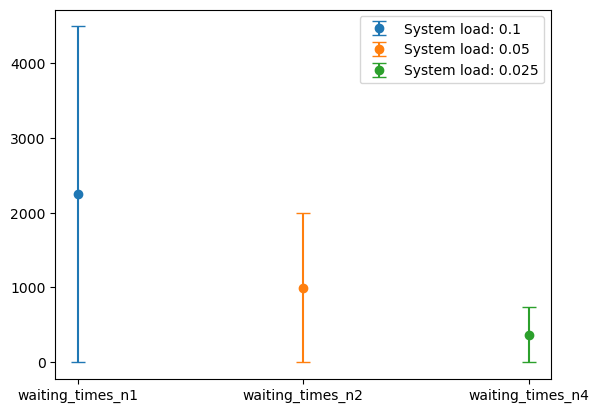

In [26]:
def plot_conf_95(waiting_times):
    mean = np.mean(waiting_times)
    
    confidence_interval =st.t.interval(confidence=0.95, df=len(waiting_times)-1, loc=mean, scale=st.sem(waiting_times))
    yerr = np.array([[confidence_interval[0], confidence_interval[1]]])
    return mean, yerr

m1, yerr1 = plot_conf_95(waiting_times_n1)
m2, yerr2 = plot_conf_95(waiting_times_n2)
m4, yerr4 = plot_conf_95(waiting_times_n4)

plt.errorbar(x='waiting_times_n1', y=m1, yerr=yerr1.T, fmt='o', capsize=5, label=f"System load: {arrival_rate/(1*mu)}")
plt.errorbar(x='waiting_times_n2', y=m2, yerr=yerr2.T, fmt='o', capsize=5, label=f"System load: {arrival_rate/(2*mu)}")
plt.errorbar(x='waiting_times_n4', y=m4, yerr=yerr4.T, fmt='o', capsize=5, label=f"System load: {arrival_rate/(4*mu)}")
plt.legend()
plt.show()


System load 1 server: 0.1
System load 2 servers: 0.05
System load 4 servers: 0.025


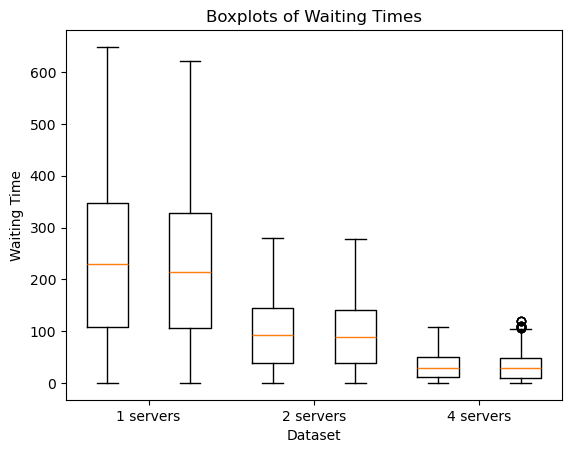

In [35]:
np.random.seed(3)

# λ – the arrival rate into the system as a whole.
# interval customers
lambd = 1

# μ – the capacity of each of n equal servers. 
mu = 10

# number of servers
n = [1,2,4]

# ρ represents the system load. ρ=λ/(n*capacity). 
print(f"System load 1 server: {lambd/(1*mu)}")
print(f"System load 2 servers: {lambd/(2*mu)}")
print(f"System load 4 servers: {lambd/(4*mu)}")

# Number of people in simulation and the number of days tested:
n_persons = 500
runs = 1000

# Waiting times
waiting_times_n1_sjf = []
waiting_times_n2_sjf = []
waiting_times_n4_sjf = []

run_simulation(lambd, n[0], mu, n_persons, waiting_times_n1_sjf, runs, 'SJF')
run_simulation(lambd, n[1], mu, n_persons, waiting_times_n2_sjf, runs, 'SJF')
run_simulation(lambd, n[2], mu, n_persons, waiting_times_n4_sjf, runs, 'SJF')

# Create positions for boxplots
positions = [1, 3, 5]
positions_sjf = [2,4,6]
# Create a boxplot
plt.boxplot([waiting_times_n1,waiting_times_n2,waiting_times_n4], positions=positions)
plt.boxplot([waiting_times_n1_sjf,waiting_times_n2_sjf,waiting_times_n4_sjf], positions=positions_sjf)
plt.title('Boxplots of Waiting Times')
plt.xlabel('Dataset')
plt.ylabel('Waiting Time')
plt.xticks([1.5,3.5,5.5], ['1 servers', '2 servers', '4 servers'])

# Show the plot
plt.show()

In [32]:
print(f"For a queue with in total {n_persons} people that get in the queue with an interval of approximately {arrival_rate} seconds for {runs} days:")
print(f"the mean waiting time was {np.mean(waiting_times_n1_sjf)}, with a standard deviation of {np.std(waiting_times_n1_sjf)}")
print(f"the mean waiting time was {np.mean(waiting_times_n2_sjf)}, with a standard deviation of {np.std(waiting_times_n2_sjf)}")
print(f"the mean waiting time was {np.mean(waiting_times_n4_sjf)}, with a standard deviation of {np.std(waiting_times_n4_sjf)}")

For a queue with in total 50 people that get in the queue with an interval of approximately 1 seconds for 100 days:
the mean waiting time was 221.85405526183789, with a standard deviation of 140.73212770051344
the mean waiting time was 92.14764881868547, with a standard deviation of 61.79224827339191
the mean waiting time was 30.62363174864148, with a standard deviation of 23.468411250365925
